# Exercise 02-2: Preparation of Python tools for linear classification

## 1. Loading the data

We start out loading all required packages:

In [2]:
import os

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='svg'

Next we load the Iris data set from:

https://archive.ics.uci.edu/ml/datasets/iris

Since this data set has become the machine learning "Hello, World!"
equivalent, it is also part of many machine learning libraries. Have a look
at the Python module  `sklearn` submodule `datasets`, for example, which was
used
[here](https://gitlab.com/dirk-deckert-lmu/maml-ss20/-/blob/master/material/lec01/iris_plot.py)
to geenrate the Iris plot for the lecture notes.

Note that the column names are missing in the CSV file. They are described in
the accompanying file
https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.names.

In [3]:
file_name = 'iris_data_set.csv'
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
column_names = ['sepal length [cm]', 'sepal width [cm]',
                'petal length [cm]', 'petal width [cm]', 'iris type']

if os.path.exists(file_name):
    print(f'Loading data from local file `{file_name}`...')
    df = pd.read_csv(file_name, names=column_names)
else:
    print(f'Loading data from `{url}`...')
    df = pd.read_csv(url, names=column_names)
    df.to_csv(file_name)
    print('Done.')

Loading data from `https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data`...
Done.


Let us inspect the data:

In [4]:
df

sepal length [cm]  sepal width [cm]  ...  petal width [cm]       iris type
0                  5.1               3.5  ...               0.2     Iris-setosa
1                  4.9               3.0  ...               0.2     Iris-setosa
2                  4.7               3.2  ...               0.2     Iris-setosa
3                  4.6               3.1  ...               0.2     Iris-setosa
4                  5.0               3.6  ...               0.2     Iris-setosa
..                 ...               ...  ...               ...             ...
145                6.7               3.0  ...               2.3  Iris-virginica
146                6.3               2.5  ...               1.9  Iris-virginica
147                6.5               3.0  ...               2.0  Iris-virginica
148                6.2               3.4  ...               2.3  Iris-virginica
149                5.9               3.0  ...               1.8  Iris-virginica

[150 rows x 5 columns]

## 2. Assignment of class labels

In [5]:

df['class'] = df['iris type'].replace(
    ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'],
    [-1, 1, 1])

## 2. Shuffling the data

We define a helper function:

In [6]:
def shuffle_df(df, training_data_fraction, random_state=None):
    '''
    Split all available data into a training and test data set.
    
    Parameters:
    -----------
    df : DataFrame
        DataFrame of available data.
    training_data_fraction : float
        The fraction of the data that should be used for training.
        E.g., `training_data_fraction=0.6` means 60%.
    random_state : int or numpy.random.RandomState, optional
        Allows to fix the seed for the pseudo-random numbers, 
        which is helpful for debugging in order to reproduce results.
    '''
    # first, we use the `sample()` function to select a fraction of the data
    # frame for the training data
    train_df = df.sample(frac=training_data_fraction, 
                         random_state=random_state)
    # second, we use the index of the just defined training data in the
    # function `drop()` that drops the respective entries from the data frame,
    # thus, leaving only the rest of the entries for our test data
    test_df = df.drop(train_df.index)
    return train_df, test_df

Which can be used as follows:

In [15]:
training_data_fraction = .8

train_df, test_df = shuffle_df(df, training_data_fraction)

# convert DataFrame entries to Numpy arrays
# `X, Y`: all data
# `train_X, train_Y`: training data
# `test_X, test_Y`: training data

X = df[['sepal length [cm]', 'sepal width [cm]']].to_numpy()
Y = df['class'].to_numpy()

train_X = train_df[['sepal length [cm]', 'sepal width [cm]']].to_numpy()
train_Y = train_df['class'].to_numpy()

test_X = test_df[['sepal length [cm]', 'sepal width [cm]']].to_numpy()
test_Y = test_df['class'].to_numpy()

print('Training data split as follows:')
print(f'  Training data samples: {len(train_df)}')
print(f'      Test data samples: {len(test_df)}')

Training data split as follows:
  Training data samples: 120
      Test data samples: 30


## 3. Plotting the training data

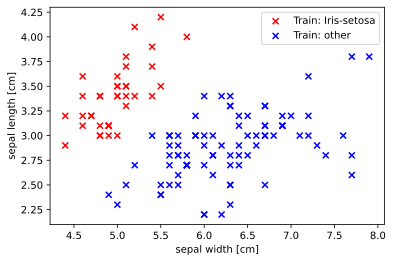

In [16]:
fig, ax = plt.subplots()

train_X_minus1 = train_X[train_Y == -1]
plt.scatter(train_X_minus1[:, 0], train_X_minus1[:, 1], marker='x', color='red', label='Train: Iris-setosa')

train_X_plus1 = train_X[train_Y == +1]
plt.scatter(train_X_plus1[:, 0], train_X_plus1[:, 1], marker='x', color='blue', label='Train: other')

plt.xlabel('sepal width [cm]')
plt.ylabel('sepal length [cm]')
plt.legend()

## 4. Defining a linear hypothesis for binary classification

We will define the hypothesis $h_{w,b}(x)=\text{sign}(w\cdot x+b)$ as a
Python class to keep track of the internal weight vector $w$ and bias term
$b$. 

In [17]:
class LinearBinaryClassification:

    def __init__(self, w, b):
        self._w = w
        self._b = b
    def h(self, x):
        # Numpy's `where` function provides a fast substitution even for larger
        # array
        return np.where(x @ self._w + self._b >= 0.0, 1, -1)

This class can now be used as follows:

In [18]:
w = np.array([1.0, -1.0])
b = -2
model = LinearBinaryClassification(w, b)

x = np.array([4, 5])

print(f'For given weight row vector w={w}, bias term b={b}, and argument vector x={x},\n'
      f'the hypothesis h evaluated at x equals {model.h(x)}.')

For given weight row vector w=[ 1. -1.], bias term b=-2, and argument vector x=[4 5],
the hypothesis h evaluated at x equals -1.


## 5. Choosing a hypothesis manually and plotting the decision regions

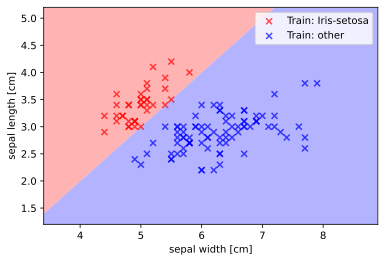

In [22]:
fig, ax = plt.subplots()

# compute how large the mesh for the contour plot shall be (with +/- 1 as
# safety bleed)
x1_min = train_X[:, 0].min() - 1
x1_max = train_X[:, 0].max() + 1
x2_min = train_X[:, 1].min() - 1
x2_max = train_X[:, 1].max() + 1

# compute grid for contour plot
x1_list, x2_list = np.meshgrid(np.arange(x1_min, x1_max, .01), 
                               np.arange(x2_min, x2_max, .01))
# meshgrid produces two arrays of the size `len(np.arange(x1_min, x1_max,
# .01))` times `len(np.arange(x2_min, x2_max, .01))` so that computations can
# be easily be vectorized.
X_list = np.dstack([x1_list, x2_list])
# present X_list to our hypothesis for evaluation
h_list = model.h(X_list)

cmap = matplotlib.colors.ListedColormap(['red', 'blue'])
plt.contourf(x1_list, x2_list, h_list, cmap=cmap, alpha=.3)

plt.scatter(train_X_minus1[:, 0], train_X_minus1[:, 1], marker='x', color='red', label='Train: Iris-setosa', alpha=.7)
plt.scatter(train_X_plus1[:, 0], train_X_plus1[:, 1], marker='x', color='blue', label='Train: other', alpha=.7)

plt.xlabel('sepal width [cm]')
plt.xlim(x1_min, x1_max)
plt.ylabel('sepal length [cm]')
plt.ylim(x2_min, x2_max)
plt.legend()

## 6. Count the number of errors in the classification of the training data

In [23]:
N = len(train_X)
train_errors = np.sum(model.h(train_X).ravel() != train_Y)
print(f'Sample size: {N}')
print(f'Number of correct classifications: {N - train_errors}')
print(f'Number of incorrect classifications: {train_errors}')

Sample size: 120
Number of correct classifications: 117
Number of incorrect classifications: 3


## 7. Adding also the test data to the plot

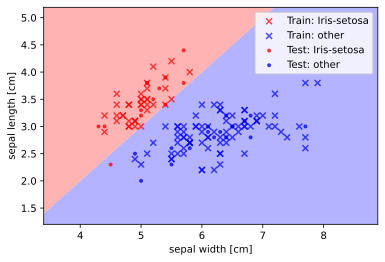

In [24]:
fig, ax = plt.subplots()

plt.contourf(x1_list, x2_list, h_list, cmap=cmap, alpha=.3)

plt.scatter(train_X_minus1[:, 0], train_X_minus1[:, 1], marker='x', color='red', label='Train: Iris-setosa', alpha=.7)
plt.scatter(train_X_plus1[:, 0], train_X_plus1[:, 1], marker='x', color='blue', label='Train: other', alpha=.7)

test_X_minus1 = test_X[test_Y == -1]
test_X_plus1 = test_X[test_Y == +1]
plt.scatter(test_X_minus1[:, 0], test_X_minus1[:, 1], marker='.', color='red', label='Test: Iris-setosa', alpha=.7)
plt.scatter(test_X_plus1[:, 0], test_X_plus1[:, 1], marker='.', color='blue', label='Test: other', alpha=.7)

plt.xlabel('sepal width [cm]')
plt.ylabel('sepal length [cm]')
plt.legend()

Compute the number of errors in predicting the classes of the test data

In [25]:
M = len(test_X)
test_errors = np.sum(model.h(test_X).ravel() != test_Y)
print(f'Sample size: {M}')
print(f'Number of correct classifications: {M - test_errors}')
print(f'Number of incorrect classifications: {test_errors}')

Sample size: 30
Number of correct classifications: 28
Number of incorrect classifications: 2


And (redundantly) the total number of classification errors for training and
test data altogether

In [26]:
total = len(X)
errors = np.sum(model.h(X).ravel() != Y)
print(f'Total sample size: {total}')
print(f'Number of correct classifications: {total - errors}')
print(f'Number of incorrect classifications: {errors}')

Total sample size: 150
Number of correct classifications: 145
Number of incorrect classifications: 5


## 8. Is the data linearly separable?

Yes. Try $w=(1, -1)$ and $b=-2.3$ and observe the total number of errors.